In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline

In [3]:
import dill
import matplotlib.pyplot as plt
# import matplotlib.transforms
import math
import numpy as np
import os
import pandas as pd
# import random
from regressors import stats as regstats
from scipy import stats
# from scipy.optimize import fsolve
# from scipy.optimize import root
# from scipy.optimize import minimize
# from scipy.stats import norm
from sklearn import linear_model
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS

pd.options.display.float_format = '{:.4f}'.format

os.chdir('D:\Documents\MGT 6090\Assignment 11')

In [ ]:
data = pd.read_pickle('data.pkl')
features = pd.read_pickle('features.pkl')[0].tolist()
ann_ret = pd.read_pickle('ann_ret.pkl')
sigma = pd.read_pickle('sigma.pkl')
E = pd.read_pickle('E.pkl')
br = pd.read_pickle('br.pkl')

In [ ]:
# import crsp data
crsp = pd.read_csv("crsp_dsf_full_DD.csv", usecols=['date', 'CUSIP', 'PERMNO',
                                                    'PRC', 'SHROUT', 'RET'], 
                   parse_dates=['date'],
                   dtype={'CUSIP': pd.StringDtype(), 'PERMNO': int, 
                          'PRC': float, 'SHROUT': float, 'RET': pd.StringDtype()})
crsp['CUSIP'] = crsp['CUSIP'].str[0:6]

# get numeric returns
crsp = crsp[pd.to_numeric(crsp['RET'], errors='coerce').notnull()]
crsp['RET'] = pd.to_numeric(crsp['RET'])

# generate lagged year column 
crsp['YEAR'] = crsp['date'].dt.year + 1

# get rid of null/na values
crsp = crsp.loc[(np.isnan(crsp['RET']) == False) & 
                 (np.isnan(crsp['PRC']) == False) & 
                 (np.isnan(crsp['SHROUT']) == False)]

# calculate daily market cap
crsp['E'] = crsp['PRC'].abs() * crsp['SHROUT'] * 1000

# calculate annual compounded return
ann_ret = crsp.groupby(by=['CUSIP', 'YEAR']).apply(lambda x: np.exp(np.sum(np.log(1+x['RET'])))).reset_index()
ann_ret.rename(columns={0:'RET'}, inplace=True)
ann_ret['RET'] = ann_ret['RET'] - 1

# calculate volatility
sigma = (crsp.groupby(by=['CUSIP', 'YEAR'])[['RET']].std() * np.sqrt(250)).reset_index()
sigma.rename(columns={'RET':'sigma'}, inplace=True)
# get rid of NaN sigma_e values
sigma = sigma.loc[np.isnan(sigma['sigma']) == False]

# calculate current market cap
E = crsp.groupby(by = ['CUSIP', 'YEAR'])['E'].first().reset_index()
# don't want to lag current market cap
E['YEAR'] = E['YEAR'] - 1

# weigh market cap by yearly total
E = E.groupby(by=['YEAR']).sum().reset_index().rename(columns={'E':'year_sum_E'}).merge(E, how='right', on=['YEAR'])
E = E.loc[E['E'] != 0]
E['E'] = np.log(E['E'] / E['year_sum_E'])
E.drop(['year_sum_E'], axis=1, inplace=True)

ann_ret.to_pickle('ann_ret.pkl')
sigma.to_pickle('sigma.pkl')
E.to_pickle('E.pkl')


In [ ]:
# import bankruptcy data
br = pd.read_csv("BR1964_2019.csv", usecols=['PERMNO', 'bankruptcy_dt'], parse_dates=['bankruptcy_dt'], dtype={'PERMNO': float})
br.dropna(inplace=True)
br['PERMNO'] = br['PERMNO'].astype(int)
br['YEAR'] = br['bankruptcy_dt'].dt.year
br_permno = br['PERMNO'].unique()
br.drop(['bankruptcy_dt'], axis=1, inplace=True)
br['br'] = 1

# use crsp data to get cusip/permno identifier
permno_cusip = pd.read_csv("crsp_dsf_full_DD.csv", usecols=['CUSIP', 'PERMNO'], 
                           dtype={'CUSIP': pd.StringDtype(), 'PERMNO': int})
permno_cusip['CUSIP'] = permno_cusip['CUSIP'].str[0:6]

# join to bankruptcy data
br = br.merge(permno_cusip, how='left', on=['PERMNO', 'YEAR'])

# get rid of values without CUSIP
br = br.loc[pd.isnull(br['CUSIP']) == False]

br.drop(['PERMNO'], axis=1, inplace=True)

# br.to_pickle('br.pkl')


In [17]:
# import and format funda data
funda_cols = ['DATADATE', 'CUSIP', 'AT',
              'INDFMT', 'DATAFMT', 'POPSRC', 'FIC', 'CONSOL',
              'SCF', 'SICH', 'COMPST',    
              'ACT', 'CH', 'PPENT',
              'DLC', 'AP', 'DLTT', 'DLTIS', 'DLTR', 'LCT', 'LT',
              'SSTK', 'PRSTKC', 'NI',
              'WCAP', 'RE', 'SALE', 'EBIT', 
              'OANCF', 'IVNCF', 'FINCF']

funda = pd.read_csv("funda.csv", usecols=funda_cols, 
                    parse_dates=['DATADATE'], 
                    dtype={'CUSIP': pd.StringDtype(), 'AT': float,
                           'INDFMT': pd.StringDtype(), 'DATAFMT': pd.StringDtype(), 'POPSRC': pd.StringDtype(), 'FIC': pd.StringDtype(), 'CONSOL': pd.StringDtype(),
                           'SCF': 'Int64', 'SICH': 'Int64', 'COMPST': pd.StringDtype(),
                           'ACT': float, 'CH': float, 'PPENT': float,
                           'DLC': float, 'AP': float, 'DLTT': float, 'DLTIS': float, 'DLTR': float, 'LCT': float, 'LT': float,
                           'SSTK': float, 'PRSTKC': float, 'NI': float,
                           'WCAP': float, 'RE': float, 'SALE': float,
                           'OANCF': float, 'IVNCF': float, 'FINCF': float})


# Attempting to mirroring Chava and Jarrow 2004
# Did not get great results

# funda = pd.read_csv("funda.csv", usecols=['DATADATE', 'CUSIP', 'AT', 
#                                           'WCAP', 'RE', 'SALE', 'NI', 'LT',
#                                           'ACT', 'LCT', 
#                                           'INDFMT', 'DATAFMT', 'POPSRC', 'FIC', 'CONSOL',
#                                           'SCF', 'SICH', 'COMPST'], 
#                     parse_dates=['DATADATE'], 
#                     dtype={'CUSIP': pd.StringDtype(), 'AT': float, 
#                            'WCAP': float, 'RE': float, 'SALE': float, 'NI': float, 'LT': float,
#                            'ACT': float, 'LCT': float,
#                            'INDFMT': pd.StringDtype(), 'DATAFMT': pd.StringDtype(), 'POPSRC': pd.StringDtype(), 'FIC': pd.StringDtype(), 'CONSOL': pd.StringDtype(),
#                            'SCF': 'Int64', 'SICH': 'Int64', 'COMPST': pd.StringDtype()})



# The algorithm performed better without the filtered values

# funda = funda.loc[(funda['INDFMT'] == 'INDL') &
#                   (funda['DATAFMT'] == 'STD') & 
#                   (funda['POPSRC'] == 'D') & 
#                   (funda['FIC'] == 'USA') & 
#                   (funda['CONSOL'] == 'C')]

# funda['SCF'] = funda['SCF'].fillna(0)
# funda = funda.loc[((funda['SCF'] >= 4) & (funda['SCF'] <= 6)) == False]

# funda['SICH'] = funda['SICH'].fillna(0)
# funda = funda.loc[((funda['SICH'] > 5999) & (funda['SICH'] < 7000)) == False]

# funda['COMPST'] = funda['COMPST'].fillna('')
# funda = funda.loc[funda['COMPST'] != 'AB']

funda = funda.loc[pd.notnull(funda['AT'])]
funda = funda.loc[funda['AT'] != 0]

# generate lagged year column
funda['YEAR'] = funda['DATADATE'].dt.year + 1

# update CUSIP
funda['CUSIP'] = funda['CUSIP'].str[0:6]

# compute variables
# funda.dropna(inplace=True)
funda[funda_cols[11:]] = funda[funda_cols[11:]].fillna(0)

for feature in funda_cols[11:]:
    funda[feature] = funda[feature] / funda['AT']

funda['NET_DEBT'] = funda['DLTIS'] - funda['DLTR']
funda['NET_EQUITY'] = funda['SSTK'] - funda['PRSTKC']

funda = funda.loc[funda['LCT'] != 0]
funda['CURR_RAT'] = funda['ACT'] / funda['LCT']

funda.drop(['AT', 'INDFMT', 'DATAFMT', 'POPSRC', 'FIC', 'CONSOL',
           'SCF', 'SICH', 'COMPST', 'DATADATE',
           'DLTIS', 'DLTR', 'SSTK', 'PRSTKC'], axis=1, inplace=True)


In [ ]:
# join crsp, compustat, and bankruptcy data
data = (funda.merge(ann_ret, how='inner', on=['CUSIP', 'YEAR'])
        .merge(sigma, how='inner', on=['CUSIP', 'YEAR'])
        .merge(E, how='inner', on=['CUSIP', 'YEAR'])
        .merge(br, how='left', on=['CUSIP', 'YEAR']))

data['br'] = data['br'].fillna(0)

# drop some columns based on some preliminary testing
data.drop(['AP', 'DLC', 'DLTT', 'RE', 'CH', 'OANCF',
           'NET_DEBT', 'NET_EQUITY'], axis=1, inplace=True)
features
# reorder columns
data_cols = data.columns.tolist()
data_cols.remove('YEAR')
data_cols.remove('CUSIP')
data_cols.insert(0, 'YEAR')
data_cols.insert(0, 'CUSIP')

data = data[data_cols]

# create list of feature columns
features = [col for col in data_cols if col not in ['YEAR', 'PERMNO', 'CUSIP', 'br']]

# pd.DataFrame(features).to_pickle('features.pkl')

# data.to_pickle('data.pkl')


In [28]:
data = pd.read_pickle('data.pkl')

# Filtering out outliers by 1/99 percentiles and using z-score,
# as well as standardizing/normalizing ended up giving worse results
# for most columns

# for feature in features:
for feature in ['E', 'RET']:

    # normalize data
    data[feature] = (data[feature] - data[feature].min()) / (data[feature].max() - data[feature].min())    
    # 1/99 quantile filtering
#     p1 = data[feature].quantile(0.01)
#     p99 = data[feature].quantile(0.99)
#     data = data.loc[(data[feature] > p1) & (data[feature] < p99)]
    
    # z score filtering
#     data = data.loc[np.abs(data[feature] - data[feature].mean()) / data[feature].std() < 3]    
    
    # standardize data 
#     data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()


In [29]:
# generate probability decile info and ks stat
def get_KS_stats(pred_y, prob_y, real_y):
    df = pd.DataFrame({'pred_val': pred_y, 'prob': prob_y, 'real_val': real_y})
    df['prob_decile'] = 10 - pd.qcut(df['prob'], 10, labels=False)

    num_events = np.sum(real_y)
    num_no_events = len(real_y) - num_events
    deciles_df = df.groupby(by='prob_decile').apply(lambda x: pd.Series({'pred_br': np.sum(x['pred_val']),
                                                                         'pred_pct_decile': np.sum(x['pred_val']) / np.sum(x['real_val']),
                                                                         'pred_pct_total': np.sum(x['pred_val']) / num_events,
                                                                         'event_pct': np.sum(x['real_val']) / num_events,
                                                                         'no_event_pct': (len(x['real_val']) - np.sum(x['real_val'])) / num_no_events}))
    deciles_df.reset_index(inplace=True)
    deciles_df['cumul_event'] = deciles_df['event_pct'].cumsum()
    deciles_df['cumul_no_event'] = deciles_df['no_event_pct'].cumsum()
    deciles_df['KS'] = deciles_df['cumul_event'] - deciles_df['cumul_no_event']
    return deciles_df


In [30]:
# in sample logistic regression
logreg = linear_model.LogisticRegression(max_iter=10000)
logreg.fit(data[features], data['br'])
# calculate predicted values and probabilities and generate stats
logreg_in_pred = logreg.predict(data[features])
logreg_in_pred_prob = logreg.predict_proba(data[features])[:, 1]
logreg_in_fpr, logreg_in_tpr, logreg_in_thresholds = metrics.roc_curve(data['br'], logreg_in_pred_prob)
logreg_in_auc = metrics.auc(logreg_in_fpr, logreg_in_tpr)
logreg_in_results = get_KS_stats(logreg_in_pred, logreg_in_pred_prob, data['br'])

logreg_in_coef = pd.DataFrame({'feature': features, 'coef': (logreg.coef_)[0]})


LogisticRegression(max_iter=10000)

In [31]:
# out of sample method 1
# split data into training and test
logreg_train1 = data.loc[data['YEAR'] <= 1990]
logreg_test1 = data.loc[data['YEAR'] > 1990]

logreg1 = linear_model.LogisticRegression(max_iter=10000)
logreg1.fit(logreg_train1[features], logreg_train1['br'])
logreg_pred1 = logreg1.predict(logreg_test1[features])
logreg_pred_prob1 = logreg1.predict_proba(logreg_test1[features])[:, 1]
logreg_out_fpr1, logreg_out_tpr1, logreg_out_thresh1 = metrics.roc_curve(logreg_test1['br'], logreg_pred_prob1)
logreg_out_auc1 = metrics.auc(logreg_out_fpr1, logreg_out_tpr1)
logreg_out_results1 = get_KS_stats(logreg_pred1, logreg_pred_prob1, logreg_test1['br'])


LogisticRegression(max_iter=10000)

In [ ]:
# out of sample method 2
logreg_test2 = []
logreg_pred2 = []
logreg_pred_prob2 = []

for year in range(1990,2019):
    # rolling forecasting using 1964-year as training data for year+1 test data
    logreg_train2 = data.loc[data['YEAR'] <= year]
    logreg_test2_yr = data.loc[data['YEAR'] == year + 1]
    logreg2 = linear_model.LogisticRegression(max_iter=10000)
    logreg2.fit(logreg_train2[features], logreg_train2['br'])
    # save predicted year values, probabilities, and corresponding test data
    logreg_pred2.extend(logreg2.predict(logreg_test2_yr[features]))
    logreg_pred_prob2.extend(logreg2.predict_proba(logreg_test2_yr[features])[:, 1])
    logreg_test2.extend(logreg_test2_yr['br'])

logreg_out_fpr2, logreg_out_tpr2, logreg_out_thresh2 = metrics.roc_curve(logreg_test2, logreg_pred_prob2)
logreg_out_auc2 = metrics.auc(logreg_out_fpr2, logreg_out_tpr2)
logreg_out_results2 = get_KS_stats(logreg_pred2, logreg_pred_prob2, logreg_test2)


In [ ]:
# out of sample method 3
logreg_test3 = []
logreg_pred3 = []
logreg_pred_prob3 = []

for i in range(2019-1990):
    # rolling forecasting using 1964+x to 1990+x as training data for 1990+x+1 year test data
    logreg_train3 = data.loc[(data['YEAR'] >= 1964 + i) & (data['YEAR'] <= 1990 + i)]
    logreg_test3_yr = data.loc[data['YEAR'] == 1990 + i + 1]
    logreg3 = linear_model.LogisticRegression(max_iter=10000)
    logreg3.fit(logreg_train3[features], logreg_train3['br'])
    # save predicted year values, probabilities, and corresponding test data
    logreg_pred3.extend(logreg3.predict(logreg_test3_yr[features]))
    logreg_pred_prob3.extend(logreg3.predict_proba(logreg_test3_yr[features])[:, 1])
    logreg_test3.extend(logreg_test3_yr['br'])

logreg_out_fpr3, logreg_out_tpr3, logreg_out_thresh3 = metrics.roc_curve(logreg_test3, logreg_pred_prob3)
logreg_out_auc3 = metrics.auc(logreg_out_fpr3, logreg_out_tpr3)
logreg_out_results3 = get_KS_stats(logreg_pred3, logreg_pred_prob3, logreg_test3)

# Selected Variables and Explanations
- Current Assets / Total Assets (-): Firms with more current assets (cash, short-term investments, receivables, inventory) have more liquidity and should be able to pay off debts easier, meaning a smaller chance of bankruptcy.
- PPENT / Total Assets (+): A rational theory explanation for value firm risk premium is that their high PPE and less liquidity lead to higher risks during bad economic times which could increase bankruptcy risk.
- LCT / Total Assets (+): A higher proportion of current liabilities due within a year is risky for firms and can increase the risk of bankruptcy.
- LT / Total Assets (+): Although less risky than high current liabilities, highly overall leveraged firms can still be riskier than less leveraged firms. 
- Current Ratio (-): A higher current ratio means it should be easier for the firm to pay off its short term liabilities and has a lower risk of bankruptcy. 
- Sales / Total Assets (-): High sales to total asset ratio mean the firm has a strong revenue stream which means it could avoid bankruptcy.
- Net Income / Total Assets (-): A strong net income means the firm is very profitable and shouldn't bankrupt easily.
- EBIT / Total Assets (-): An alternative insight on the firm's profitability without interest and taxes.
- Investing Activities - Net Cash Flow / Total Assets (-): If the firm has enough extra cash flow to have a high investing activities ratio, the firm is probably stable and profitable enough to be at low risk of bankruptcy.
- Financing Activities - Net Cash Flow / Total Assets (-): High financing activities means more money is flowing into the company than out.
- WCAP / Total Assets (-): A measure of the firm's liquidity, operational efficiency, and short-term financial health. If this is positive, the firm should be able to fund current operations and invest in future growth.
- Sigma (+): If a firm's yearly stock volatility is higher, it should be riskier and at higher risk of bankruptcy.
- Yearly Return (-): A firm with a high yearly stock return means the firm is performing well and at a lower risk of bankruptcy.
- Market Capitalization (-): A firm with a larger market capitalization is more established and has a better foundation to avoid bankruptcy.

# Logistic Regression ROC Curves and AUC

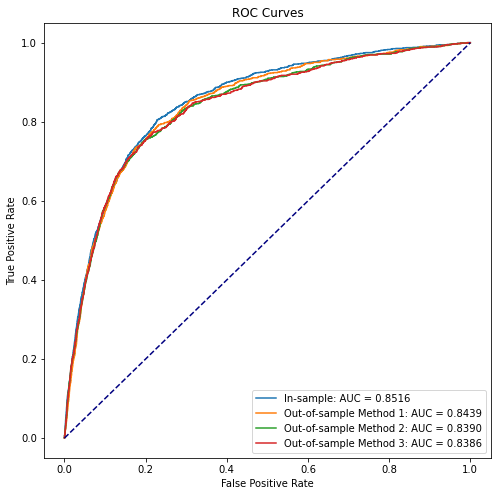

In [131]:
# Plot ROC curves
plt.figure(figsize=(8,8))
plt.plot(logreg_in_fpr, logreg_in_tpr, label='In-sample: AUC = %0.4f' % logreg_in_auc)
plt.plot(logreg_out_fpr1, logreg_out_tpr1, label='Out-of-sample Method 1: AUC = %0.4f' % logreg_out_auc1)
plt.plot(logreg_out_fpr2, logreg_out_tpr2, label='Out-of-sample Method 2: AUC = %0.4f' % logreg_out_auc2)
plt.plot(logreg_out_fpr3, logreg_out_tpr3, label='Out-of-sample Method 3: AUC = %0.4f' % logreg_out_auc3)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show();

# Logistic Regression In-sample Coefficients

In [109]:
logreg_in_coef

,feature,coef
0,ACT,1.946188
1,EBIT,-0.007194
2,FINCF,-0.023278
3,IVNCF,0.021908
4,LCT,-0.786782
5,LT,0.275363
6,NI,0.003821
7,PPENT,0.774627
8,SALE,-0.090122
9,WCAP,-0.530300


A majority of the hypothesized coefficients were correct. Current assets and current liabilities were not predicted correctly, although the current coefficients could be incorrect because of additionally correlated variables like the current ratio and total liabilities. Net income was also different, but this could have issues since it could be correlated with sales and EBIT.

# Logistic Regression In-sample Decile and KS Info

In [37]:
logreg_in_results

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,19.0000,0.0219,0.0125,0.5740,0.0966,0.5740,0.0966,0.4774
1,2,0.0000,0.0000,0.0000,0.1869,0.0994,0.7609,0.1960,0.5649
2,3,0.0000,0.0000,0.0000,0.0878,0.1001,0.8487,0.2961,0.5527
3,4,0.0000,0.0000,0.0000,0.0489,0.1004,0.8976,0.3964,0.5012
4,5,0.0000,0.0000,0.0000,0.0304,0.1005,0.9280,0.4969,0.4311
5,6,0.0000,0.0000,0.0000,0.0198,0.1006,0.9478,0.5975,0.3503
6,7,0.0000,0.0000,0.0000,0.0192,0.1006,0.9670,0.6981,0.2689
7,8,0.0000,0.0000,0.0000,0.0159,0.1006,0.9828,0.7987,0.1841
8,9,0.0000,0.0000,0.0000,0.0086,0.1007,0.9914,0.8993,0.0921
9,10,0.0000,0.0000,0.0000,0.0086,0.1007,1.0000,1.0000,0.0000


# Logistic Regression Out-of-sample Method 1 Decile and KS Info

In [39]:
logreg_out_results1

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,220.0000,0.3908,0.2191,0.5608,0.0964,0.5608,0.0964,0.4644
1,2,0.0000,0.0000,0.0000,0.1892,0.0993,0.7500,0.1957,0.5543
2,3,0.0000,0.0000,0.0000,0.0876,0.1001,0.8376,0.2958,0.5419
3,4,0.0000,0.0000,0.0000,0.0518,0.1004,0.8894,0.3962,0.4933
4,5,0.0000,0.0000,0.0000,0.0299,0.1005,0.9193,0.4967,0.4226
5,6,0.0000,0.0000,0.0000,0.0279,0.1006,0.9472,0.5973,0.3499
6,7,0.0000,0.0000,0.0000,0.0139,0.1007,0.9612,0.6979,0.2632
7,8,0.0000,0.0000,0.0000,0.0139,0.1007,0.9751,0.7986,0.1765
8,9,0.0000,0.0000,0.0000,0.0149,0.1007,0.9900,0.8993,0.0908
9,10,0.0000,0.0000,0.0000,0.0100,0.1007,1.0000,1.0000,-0.0000


# Logistic Regression Out-of-sample Method 2 Decile and KS Info

In [41]:
logreg_out_results2

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,57.0000,0.0986,0.0568,0.5757,0.0963,0.5757,0.0963,0.4794
1,2,0.0000,0.0000,0.0000,0.1753,0.0994,0.7510,0.1957,0.5553
2,3,0.0000,0.0000,0.0000,0.0807,0.1002,0.8317,0.2958,0.5358
3,4,0.0000,0.0000,0.0000,0.0418,0.1005,0.8735,0.3963,0.4772
4,5,0.0000,0.0000,0.0000,0.0339,0.1005,0.9074,0.4968,0.4106
5,6,0.0000,0.0000,0.0000,0.0239,0.1006,0.9313,0.5974,0.3339
6,7,0.0000,0.0000,0.0000,0.0279,0.1006,0.9592,0.6980,0.2612
7,8,0.0000,0.0000,0.0000,0.0120,0.1007,0.9711,0.7987,0.1725
8,9,0.0000,0.0000,0.0000,0.0179,0.1006,0.9890,0.8993,0.0897
9,10,0.0000,0.0000,0.0000,0.0110,0.1007,1.0000,1.0000,-0.0000


# Logistic Regression Out-of-sample Method 3 Decile and KS Info

In [43]:
logreg_out_results3

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,57.0000,0.0984,0.0568,0.5767,0.0963,0.5767,0.0963,0.4804
1,2,0.0000,0.0000,0.0000,0.1743,0.0994,0.7510,0.1957,0.5553
2,3,0.0000,0.0000,0.0000,0.0747,0.1002,0.8257,0.2959,0.5298
3,4,0.0000,0.0000,0.0000,0.0438,0.1004,0.8695,0.3963,0.4732
4,5,0.0000,0.0000,0.0000,0.0339,0.1005,0.9034,0.4968,0.4066
5,6,0.0000,0.0000,0.0000,0.0239,0.1006,0.9273,0.5974,0.3299
6,7,0.0000,0.0000,0.0000,0.0299,0.1005,0.9572,0.6980,0.2592
7,8,0.0000,0.0000,0.0000,0.0149,0.1007,0.9721,0.7986,0.1735
8,9,0.0000,0.0000,0.0000,0.0169,0.1007,0.9890,0.8993,0.0897
9,10,0.0000,0.0000,0.0000,0.0110,0.1007,1.0000,1.0000,-0.0000


In all three methods, the majority of defaults are in decile 1, which is as desired, although the number of predicted bankruptcies is relatively low. Method 1 has the highest number of predicted bankruptcies with 220 in the first decile, which was about 40% of the number of bankruptcies that actually occured in the first decile. 

The KS stat will be the largest KS value across our deciles for each method. Each method has the KS stat of around 0.55 and falls in the second decile, which are good indicators for the model.

In [ ]:
# lasso regression on in-sample data
lasso_in = linear_model.LassoCV(max_iter=10000)
lasso_in.fit(data[features], data['br'])
lasso_feat = [features[i] for i in range(len(features)) if (lasso_in.coef_)[i] != 0]
lasso_lambda = lasso_in.alpha_
lasso_in.coef_

# Lasso Regression Best Covariates

In [45]:
lasso_feat

['LT', 'CURR_RAT', 'sigma']

Using a LASSO Logistic regression, we find that the Total Liabilities, Current Ratio, and return volatility are strong covariates for our post Lasso logistic regression.

# Lasso Regression Optimal Lambda

In [46]:
lasso_lambda

0.002084685077367002

In [ ]:
# post lasso regressions
# in sample logistic regression
post_lasso_in = linear_model.LogisticRegression(max_iter=10000)
post_lasso_in.fit(data[lasso_feat], data['br'])
# calculate predicted values and probabilities and generate stats
post_lasso_in_pred = post_lasso_in.predict(data[lasso_feat])
post_lasso_in_pred_prob = post_lasso_in.predict_proba(data[lasso_feat])[:, 1]
post_lasso_in_fpr, post_lasso_in_tpr, post_lasso_in_thresholds = metrics.roc_curve(data['br'], post_lasso_in_pred_prob)
post_lasso_in_auc = metrics.auc(post_lasso_in_fpr, post_lasso_in_tpr)
post_lasso_in_results = get_KS_stats(post_lasso_in_pred, post_lasso_in_pred_prob, data['br'])
post_lasso_in_coef = pd.DataFrame({'feature': lasso_feat, 'coef': (post_lasso_in.coef_)[0]})

# out of sample method 1
# split data into training and test
post_lasso_train1 = data.loc[data['YEAR'] <= 1990]
post_lasso_test1 = data.loc[data['YEAR'] > 1990]

post_lasso1 = linear_model.LogisticRegression(max_iter=10000)
post_lasso1.fit(post_lasso_train1[lasso_feat], post_lasso_train1['br'])
post_lasso_pred1 = post_lasso1.predict(post_lasso_test1[lasso_feat])
post_lasso_pred_prob1 = post_lasso1.predict_proba(post_lasso_test1[lasso_feat])[:, 1]
post_lasso_out_fpr1, post_lasso_out_tpr1, post_lasso_out_thresh1 = metrics.roc_curve(post_lasso_test1['br'], post_lasso_pred_prob1)
post_lasso_out_auc1 = metrics.auc(post_lasso_out_fpr1, post_lasso_out_tpr1)
post_lasso_out_results1 = get_KS_stats(post_lasso_pred1, post_lasso_pred_prob1, post_lasso_test1['br'])

# out of sample method 2
post_lasso_test2 = []
post_lasso_pred2 = []
post_lasso_pred_prob2 = []

for year in range(1990,2019):
    # rolling forecasting using 1964-year as training data for year+1 test data
    post_lasso_train2 = data.loc[data['YEAR'] <= year]
    post_lasso_test2_yr = data.loc[data['YEAR'] == year + 1]
    post_lasso2 = linear_model.LogisticRegression(max_iter=10000)
    post_lasso2.fit(post_lasso_train2[features], post_lasso_train2['br'])
    # save predicted year values, probabilities, and corresponding test data
    post_lasso_pred2.extend(post_lasso2.predict(post_lasso_test2_yr[features]))
    post_lasso_pred_prob2.extend(post_lasso2.predict_proba(post_lasso_test2_yr[features])[:, 1])
    post_lasso_test2.extend(post_lasso_test2_yr['br'])

post_lasso_out_fpr2, post_lasso_out_tpr2, post_lasso_out_thresh2 = metrics.roc_curve(post_lasso_test2, post_lasso_pred_prob2)
post_lasso_out_auc2 = metrics.auc(post_lasso_out_fpr2, post_lasso_out_tpr2)
post_lasso_out_results2 = get_KS_stats(post_lasso_pred2, post_lasso_pred_prob2, post_lasso_test2)


# out of sample method 3
post_lasso_test3 = []
post_lasso_pred3 = []
post_lasso_pred_prob3 = []

for i in range(2019-1990):
    # rolling forecasting using 1964+x to 1990+x as training data for 1990+x+1 year test data
    post_lasso_train3 = data.loc[(data['YEAR'] >= 1964 + i) & (data['YEAR'] <= 1990 + i)]
    post_lasso_test3_yr = data.loc[data['YEAR'] == 1990 + i + 1]
    post_lasso3 = linear_model.LogisticRegression(max_iter=10000)
    post_lasso3.fit(post_lasso_train3[lasso_feat], post_lasso_train3['br'])
    # save predicted year values, probabilities, and corresponding test data
    post_lasso_pred3.extend(post_lasso3.predict(post_lasso_test3_yr[lasso_feat]))
    post_lasso_pred_prob3.extend(post_lasso3.predict_proba(post_lasso_test3_yr[lasso_feat])[:, 1])
    post_lasso_test3.extend(post_lasso_test3_yr['br'])

post_lasso_out_fpr3, post_lasso_out_tpr3, post_lasso_out_thresh3 = metrics.roc_curve(post_lasso_test3, post_lasso_pred_prob3)
post_lasso_out_auc3 = metrics.auc(post_lasso_out_fpr3, post_lasso_out_tpr3)
post_lasso_out_results3 = get_KS_stats(post_lasso_pred3, post_lasso_pred_prob3, post_lasso_test3)

# Post LASSO Logistic Regression ROC Curves

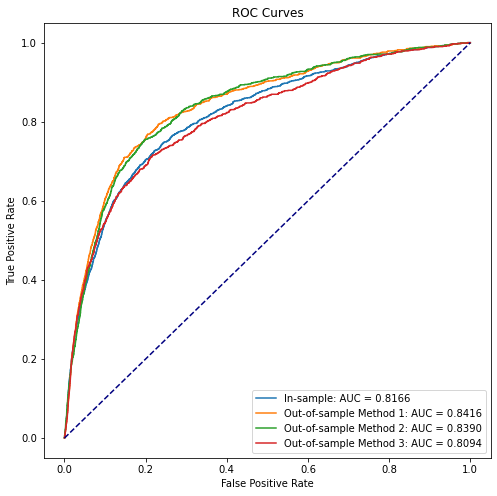

In [133]:
# Plot ROC curves
plt.figure(figsize=(8,8))
plt.plot(post_lasso_in_fpr, post_lasso_in_tpr, label='In-sample: AUC = %0.4f' % post_lasso_in_auc)
plt.plot(post_lasso_out_fpr1, post_lasso_out_tpr1, label='Out-of-sample Method 1: AUC = %0.4f' % post_lasso_out_auc1)
plt.plot(post_lasso_out_fpr2, post_lasso_out_tpr2, label='Out-of-sample Method 2: AUC = %0.4f' % post_lasso_out_auc2)
plt.plot(post_lasso_out_fpr3, post_lasso_out_tpr3, label='Out-of-sample Method 3: AUC = %0.4f' % post_lasso_out_auc3)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show();

# Post LASSO Logistic Regression In-sample Coefficients

In [49]:
post_lasso_in_coef

,feature,coef
0,LT,0.0300
1,CURR_RAT,-0.6267
2,sigma,0.8909


The regression coefficients using these three covariates are as initially predicted.

# Post LASSO Logistic Regression In-sample Decile and KS Info

In [53]:
post_lasso_in_results

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,51.0000,0.0630,0.0337,0.5350,0.0969,0.5350,0.0969,0.4381
1,2,0.0000,0.0000,0.0000,0.1631,0.0995,0.6982,0.1964,0.5017
2,3,0.0000,0.0000,0.0000,0.0819,0.1001,0.7801,0.2966,0.4835
3,4,0.0000,0.0000,0.0000,0.0588,0.1003,0.8388,0.3969,0.4420
4,5,0.0000,0.0000,0.0000,0.0410,0.1004,0.8798,0.4973,0.3825
5,6,0.0000,0.0000,0.0000,0.0363,0.1005,0.9161,0.5977,0.3184
6,7,0.0000,0.0000,0.0000,0.0264,0.1005,0.9425,0.6983,0.2443
7,8,0.0000,0.0000,0.0000,0.0291,0.1005,0.9716,0.7988,0.1728
8,9,0.0000,0.0000,0.0000,0.0165,0.1006,0.9881,0.8994,0.0887
9,10,0.0000,0.0000,0.0000,0.0119,0.1006,1.0000,1.0000,-0.0000


# Post LASSO Logistic Regression Out-of-sample Method 1 Decile and KS Info

In [57]:
post_lasso_out_results1

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,233.0000,0.3942,0.2321,0.5886,0.0962,0.5886,0.0962,0.4925
1,2,0.0000,0.0000,0.0000,0.1624,0.0995,0.7510,0.1957,0.5553
2,3,0.0000,0.0000,0.0000,0.0747,0.1002,0.8257,0.2959,0.5298
3,4,0.0000,0.0000,0.0000,0.0438,0.1004,0.8695,0.3963,0.4732
4,5,0.0000,0.0000,0.0000,0.0319,0.1005,0.9014,0.4968,0.4045
5,6,0.0000,0.0000,0.0000,0.0259,0.1006,0.9273,0.5974,0.3299
6,7,0.0000,0.0000,0.0000,0.0319,0.1005,0.9592,0.6980,0.2612
7,8,0.0000,0.0000,0.0000,0.0199,0.1006,0.9791,0.7986,0.1805
8,9,0.0000,0.0000,0.0000,0.0110,0.1007,0.9900,0.8993,0.0908
9,10,0.0000,0.0000,0.0000,0.0100,0.1007,1.0000,1.0000,-0.0000


# Post LASSO Logistic Regression Out-of-sample Method 2 Decile and KS Info

In [61]:
post_lasso_out_results2

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,57.0000,0.0986,0.0568,0.5757,0.0963,0.5757,0.0963,0.4794
1,2,0.0000,0.0000,0.0000,0.1753,0.0994,0.7510,0.1957,0.5553
2,3,0.0000,0.0000,0.0000,0.0807,0.1002,0.8317,0.2958,0.5358
3,4,0.0000,0.0000,0.0000,0.0418,0.1005,0.8735,0.3963,0.4772
4,5,0.0000,0.0000,0.0000,0.0339,0.1005,0.9074,0.4968,0.4106
5,6,0.0000,0.0000,0.0000,0.0239,0.1006,0.9313,0.5974,0.3339
6,7,0.0000,0.0000,0.0000,0.0279,0.1006,0.9592,0.6980,0.2612
7,8,0.0000,0.0000,0.0000,0.0120,0.1007,0.9711,0.7987,0.1725
8,9,0.0000,0.0000,0.0000,0.0179,0.1006,0.9890,0.8993,0.0897
9,10,0.0000,0.0000,0.0000,0.0110,0.1007,1.0000,1.0000,-0.0000


# Post LASSO Logistic Regression Out-of-sample Method 3 Decile and KS Info

In [65]:
post_lasso_out_results3

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,79.0000,0.1455,0.0787,0.5408,0.0965,0.5408,0.0965,0.4443
1,2,0.0000,0.0000,0.0000,0.1434,0.0997,0.6843,0.1962,0.4881
2,3,0.0000,0.0000,0.0000,0.0787,0.1002,0.7629,0.2964,0.4666
3,4,0.0000,0.0000,0.0000,0.0578,0.1003,0.8207,0.3967,0.4240
4,5,0.0000,0.0000,0.0000,0.0418,0.1005,0.8625,0.4972,0.3654
5,6,0.0000,0.0000,0.0000,0.0349,0.1005,0.8974,0.5977,0.2997
6,7,0.0000,0.0000,0.0000,0.0438,0.1004,0.9412,0.6981,0.2431
7,8,0.0000,0.0000,0.0000,0.0299,0.1005,0.9711,0.7987,0.1725
8,9,0.0000,0.0000,0.0000,0.0169,0.1007,0.9880,0.8993,0.0887
9,10,0.0000,0.0000,0.0000,0.0120,0.1007,1.0000,1.0000,-0.0000


We find similar results to the initial logistic regression. All predicted bankruptcies are in the first decile, and method 1 has the highest number of bankruptcies predicted within the decile, again around 40%. The KS statistic is still the highest in the second decile, and for most methods is still around 0.55

In [66]:
# ridge regression on in-sample data
ridge_in = linear_model.RidgeCV()
ridge_in.fit(data[features], data['br'])
ridge_lambda = ridge_in.alpha_
# get p values for ridge regression coefficients
ridge_p = regstats.coef_pval(ridge_in, data[features], data['br'])
ridge_feat = [features[i] for i in range(len(features)) if ridge_p[i] <= 0.001]

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

# Ridge Regression Best Covariates using p-value

In [67]:
ridge_feat

['ACT', 'FINCF', 'NI', 'PPENT', 'SALE', 'sigma', 'E']

Using a ridge logistic regression and coefficient p-values, we select the current liabilities, financing activity net cash flow, net income, property plant and equipment, sales, volatility, and market capitalization.

# Ridge Regression Optimal Lambda

In [68]:
ridge_lambda

0.1

In [ ]:
# post ridge regressions
# in sample logistic regression
post_ridge_in = linear_model.LogisticRegression(max_iter=10000)
post_ridge_in.fit(data[ridge_feat], data['br'])
# calculate predicted values and probabilities and generate stats
post_ridge_in_pred = post_ridge_in.predict(data[ridge_feat])
post_ridge_in_pred_prob = post_ridge_in.predict_proba(data[ridge_feat])[:, 1]
post_ridge_in_fpr, post_ridge_in_tpr, post_ridge_in_thresholds = metrics.roc_curve(data['br'], post_ridge_in_pred_prob)
post_ridge_in_auc = metrics.auc(post_ridge_in_fpr, post_ridge_in_tpr)
post_ridge_in_results = get_KS_stats(post_ridge_in_pred, post_ridge_in_pred_prob, data['br'])
post_ridge_in_coef = pd.DataFrame({'feature': ridge_feat, 'coef': (post_ridge_in.coef_)[0]})

# out of sample method 1
# split data into training and test
post_ridge_train1 = data.loc[data['YEAR'] <= 1990]
post_ridge_test1 = data.loc[data['YEAR'] > 1990]

post_ridge1 = linear_model.LogisticRegression(max_iter=10000)
post_ridge1.fit(post_ridge_train1[ridge_feat], post_ridge_train1['br'])
post_ridge_pred1 = post_ridge1.predict(post_ridge_test1[ridge_feat])
post_ridge_pred_prob1 = post_ridge1.predict_proba(post_ridge_test1[ridge_feat])[:, 1]
post_ridge_out_fpr1, post_ridge_out_tpr1, post_ridge_out_thresh1 = metrics.roc_curve(post_ridge_test1['br'], post_ridge_pred_prob1)
post_ridge_out_auc1 = metrics.auc(post_ridge_out_fpr1, post_ridge_out_tpr1)
post_ridge_out_results1 = get_KS_stats(post_ridge_pred1, post_ridge_pred_prob1, post_ridge_test1['br'])

# out of sample method 2
post_ridge_test2 = []
post_ridge_pred2 = []
post_ridge_pred_prob2 = []

for year in range(1990,2019):
    # rolling forecasting using 1964-year as training data for year+1 test data
    post_ridge_train2 = data.loc[data['YEAR'] <= year]
    post_ridge_test2_yr = data.loc[data['YEAR'] == year + 1]
    post_ridge2 = linear_model.LogisticRegression(max_iter=10000)
    post_ridge2.fit(post_ridge_train2[features], post_ridge_train2['br'])
    # save predicted year values, probabilities, and corresponding test data
    post_ridge_pred2.extend(post_ridge2.predict(post_ridge_test2_yr[features]))
    post_ridge_pred_prob2.extend(post_ridge2.predict_proba(post_ridge_test2_yr[features])[:, 1])
    post_ridge_test2.extend(post_ridge_test2_yr['br'])

post_ridge_out_fpr2, post_ridge_out_tpr2, post_ridge_out_thresh2 = metrics.roc_curve(post_ridge_test2, post_ridge_pred_prob2)
post_ridge_out_auc2 = metrics.auc(post_ridge_out_fpr2, post_ridge_out_tpr2)
post_ridge_out_results2 = get_KS_stats(post_ridge_pred2, post_ridge_pred_prob2, post_ridge_test2)


# out of sample method 3
post_ridge_test3 = []
post_ridge_pred3 = []
post_ridge_pred_prob3 = []

for i in range(2019-1990):
    # rolling forecasting using 1964+x to 1990+x as training data for 1990+x+1 year test data
    post_ridge_train3 = data.loc[(data['YEAR'] >= 1964 + i) & (data['YEAR'] <= 1990 + i)]
    post_ridge_test3_yr = data.loc[data['YEAR'] == 1990 + i + 1]
    post_ridge3 = linear_model.LogisticRegression(max_iter=10000)
    post_ridge3.fit(post_ridge_train3[ridge_feat], post_ridge_train3['br'])
    # save predicted year values, probabilities, and corresponding test data
    post_ridge_pred3.extend(post_ridge3.predict(post_ridge_test3_yr[ridge_feat]))
    post_ridge_pred_prob3.extend(post_ridge3.predict_proba(post_ridge_test3_yr[ridge_feat])[:, 1])
    post_ridge_test3.extend(post_ridge_test3_yr['br'])

post_ridge_out_fpr3, post_ridge_out_tpr3, post_ridge_out_thresh3 = metrics.roc_curve(post_ridge_test3, post_ridge_pred_prob3)
post_ridge_out_auc3 = metrics.auc(post_ridge_out_fpr3, post_ridge_out_tpr3)
post_ridge_out_results3 = get_KS_stats(post_ridge_pred3, post_ridge_pred_prob3, post_ridge_test3)

# Post Ridge Logistic Regression ROC Curves

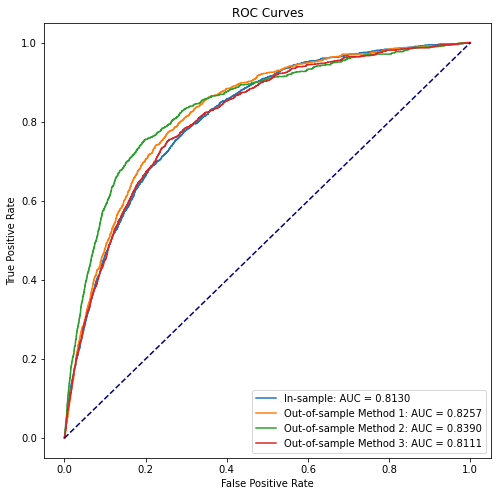

In [134]:
# Plot ROC curves
plt.figure(figsize=(8,8))
plt.plot(post_ridge_in_fpr, post_ridge_in_tpr, label='In-sample: AUC = %0.4f' % post_ridge_in_auc)
plt.plot(post_ridge_out_fpr1, post_ridge_out_tpr1, label='Out-of-sample Method 1: AUC = %0.4f' % post_ridge_out_auc1)
plt.plot(post_ridge_out_fpr2, post_ridge_out_tpr2, label='Out-of-sample Method 2: AUC = %0.4f' % post_ridge_out_auc2)
plt.plot(post_ridge_out_fpr3, post_ridge_out_tpr3, label='Out-of-sample Method 3: AUC = %0.4f' % post_ridge_out_auc3)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show();

# Post Ridge Logistic Regression In-sample Coefficients

In [71]:
post_ridge_in_coef

,feature,coef
0,ACT,-0.5755
1,FINCF,0.0153
2,NI,-0.0017
3,PPENT,0.7096
4,SALE,0.0236
5,sigma,0.5009
6,E,-7.9673


Most of the hypothesized signs were correct, aside from financing activites net cash flow and sales.

# Post Ridge Logistic Regression In-sample Decile and KS Info

In [75]:
post_ridge_in_results

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,21.0000,0.0306,0.0139,0.4531,0.0975,0.4531,0.0975,0.3556
1,2,0.0000,0.0000,0.0000,0.2061,0.0992,0.6592,0.1967,0.4625
2,3,0.0000,0.0000,0.0000,0.1169,0.0999,0.7761,0.2966,0.4795
3,4,0.0000,0.0000,0.0000,0.0773,0.1002,0.8534,0.3967,0.4566
4,5,0.0000,0.0000,0.0000,0.0581,0.1003,0.9115,0.4970,0.4144
5,6,0.0000,0.0000,0.0000,0.0403,0.1004,0.9518,0.5975,0.3543
6,7,0.0000,0.0000,0.0000,0.0172,0.1006,0.9690,0.6981,0.2709
7,8,0.0000,0.0000,0.0000,0.0145,0.1006,0.9835,0.7987,0.1848
8,9,0.0000,0.0000,0.0000,0.0112,0.1006,0.9947,0.8993,0.0954
9,10,0.0000,0.0000,0.0000,0.0053,0.1007,1.0000,1.0000,0.0000


# Post Ridge Logistic Regression Out-of-sample Method 1 Decile and KS Info

In [79]:
post_ridge_out_results1

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,335.0000,0.7128,0.3337,0.4681,0.0971,0.4681,0.0971,0.3710
1,2,0.0000,0.0000,0.0000,0.2301,0.0990,0.6982,0.1961,0.5021
2,3,0.0000,0.0000,0.0000,0.1116,0.0999,0.8098,0.2960,0.5138
3,4,0.0000,0.0000,0.0000,0.0697,0.1002,0.8795,0.3962,0.4832
4,5,0.0000,0.0000,0.0000,0.0428,0.1004,0.9223,0.4967,0.4256
5,6,0.0000,0.0000,0.0000,0.0259,0.1006,0.9482,0.5973,0.3509
6,7,0.0000,0.0000,0.0000,0.0229,0.1006,0.9711,0.6979,0.2732
7,8,0.0000,0.0000,0.0000,0.0120,0.1007,0.9831,0.7986,0.1845
8,9,0.0000,0.0000,0.0000,0.0080,0.1007,0.9910,0.8993,0.0918
9,10,0.0000,0.0000,0.0000,0.0090,0.1007,1.0000,1.0000,-0.0000


# Post Ridge Logistic Regression Out-of-sample Method 2 Decile and KS Info

In [83]:
post_ridge_out_results2

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,57.0000,0.0986,0.0568,0.5757,0.0963,0.5757,0.0963,0.4794
1,2,0.0000,0.0000,0.0000,0.1753,0.0994,0.7510,0.1957,0.5553
2,3,0.0000,0.0000,0.0000,0.0807,0.1002,0.8317,0.2958,0.5358
3,4,0.0000,0.0000,0.0000,0.0418,0.1005,0.8735,0.3963,0.4772
4,5,0.0000,0.0000,0.0000,0.0339,0.1005,0.9074,0.4968,0.4106
5,6,0.0000,0.0000,0.0000,0.0239,0.1006,0.9313,0.5974,0.3339
6,7,0.0000,0.0000,0.0000,0.0279,0.1006,0.9592,0.6980,0.2612
7,8,0.0000,0.0000,0.0000,0.0120,0.1007,0.9711,0.7987,0.1725
8,9,0.0000,0.0000,0.0000,0.0179,0.1006,0.9890,0.8993,0.0897
9,10,0.0000,0.0000,0.0000,0.0110,0.1007,1.0000,1.0000,-0.0000


# Post Ridge Logistic Regression Out-of-sample Method 3 Decile and KS Info

In [87]:
post_ridge_out_results3

,prob_decile,pred_br,pred_pct_decile,pred_pct_total,event_pct,no_event_pct,cumul_event,cumul_no_event,KS
0,1,60.0000,0.1342,0.0598,0.4452,0.0973,0.4452,0.0973,0.3479
1,2,0.0000,0.0000,0.0000,0.2201,0.0991,0.6653,0.1963,0.4690
2,3,0.0000,0.0000,0.0000,0.1175,0.0999,0.7829,0.2962,0.4867
3,4,0.0000,0.0000,0.0000,0.0687,0.1002,0.8516,0.3965,0.4551
4,5,0.0000,0.0000,0.0000,0.0508,0.1004,0.9024,0.4968,0.4056
5,6,0.0000,0.0000,0.0000,0.0418,0.1005,0.9442,0.5973,0.3469
6,7,0.0000,0.0000,0.0000,0.0199,0.1006,0.9641,0.6979,0.2662
7,8,0.0000,0.0000,0.0000,0.0169,0.1007,0.9811,0.7986,0.1825
8,9,0.0000,0.0000,0.0000,0.0060,0.1007,0.9871,0.8993,0.0877
9,10,0.0000,0.0000,0.0000,0.0129,0.1007,1.0000,1.0000,-0.0000


Once again, all predicted bankruptcies are in the first decile, and method 1 has the highest number of bankruptcies predicted within the decile. However, with the selected covariates, there are 335 predicted bankruptcies or about 70% of the total bankruptcies in the decile, significantly better than both previous measures. The KS statistic is still the highest in the second decile, although it did drop by a few basis points for some methods.

# K-Nearest Neighbor

For the K-nearest-neighbors model, we will use ridge regression selected covariates, as these had the best performance at predicting bankruptcy. A general starting point for number of neighbors I have previously used is sqrt(n) where n is the number of samples in the training set, but I decided to check  smaller numbers of neighbors from 1 to 30 as well.

In [ ]:
# out of sample method 1
# split data into training and test
knn_train = data.loc[data['YEAR'] <= 1990]
knn_test = data.loc[data['YEAR'] > 1990]
# for storing misclassification rates
knn_misclass = []
n_neighbors = list(range(1, 31))
n_neighbors.append(int(round(math.sqrt(len(knn_train)))))
for i in n_neighbors:
    # fit knn and get predictions
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(knn_train[ridge_feat], knn_train['br'])
    knn_pred = knn.predict(knn_test[ridge_feat])
    # store misclassification rate
    knn_misclass.append(1 - metrics.accuracy_score(knn_test['br'], knn_pred))

knn_df = pd.DataFrame({'n_neighbors': n_neighbors, 'misclass_rate': knn_misclass})


# K-Nearest Neighbor Method 1 Misclassification Rates

In [108]:
knn_df

,n_neighbors,misclass_rate
0,1,0.018395
1,2,0.008169
2,3,0.008945
3,4,0.007944
4,5,0.008192
5,6,0.007858
6,7,0.007889
7,8,0.007827
8,9,0.007850
9,10,0.007796


Since increasing the number of neighbors past 12 has drastically diminishing returns, for the other 2 method KNN computations, we will use 12 neighbors.

In [ ]:
# Calculate other misclassification rates
# out of sample method 2
knn_test2 = []
knn_pred2 = []
for year in range(1990,2019):
    # rolling forecasting using 1964-year as training data for year+1 test data
    knn_train2 = data.loc[data['YEAR'] <= year]
    knn_test2_yr = data.loc[data['YEAR'] == year + 1]
    knn2 = KNeighborsClassifier(n_neighbors=12)
    knn2.fit(knn_train2[features], knn_train2['br'])
    # save predicted year values, probabilities, and corresponding test data
    knn_pred2.extend(knn2.predict(knn_test2_yr[features]))
    knn_test2.extend(knn_test2_yr['br'])

# out of sample method 3
knn_test3 = []
knn_pred3 = []
for i in range(2019-1990):
    # rolling forecasting using 1964+x to 1990+x as training data for 1990+x+1 year test data
    knn_train3 = data.loc[(data['YEAR'] >= 1964 + i) & (data['YEAR'] <= 1990 + i)]
    knn_test3_yr = data.loc[data['YEAR'] == 1990 + i + 1]
    knn3 = KNeighborsClassifier(n_neighbors=12)
    knn3.fit(knn_train3[ridge_feat], knn_train3['br'])
    # save predicted year values, probabilities, and corresponding test data
    knn_pred3.extend(knn3.predict(knn_test3_yr[ridge_feat]))
    knn_test3.extend(knn_test3_yr['br'])


In [1]:
# generate df with misclassification rates
logreg_misclass = []
logreg_misclass.append(1 - metrics.accuracy_score(logreg_test1['br'], logreg_pred1))
logreg_misclass.append(1 - metrics.accuracy_score(logreg_test2, logreg_pred2))
logreg_misclass.append(1 - metrics.accuracy_score(logreg_test3, logreg_pred3))

post_lasso_misclass = []
post_lasso_misclass.append(1 - metrics.accuracy_score(post_lasso_test1['br'], post_lasso_pred1))
post_lasso_misclass.append(1 - metrics.accuracy_score(post_lasso_test2, post_lasso_pred2))
post_lasso_misclass.append(1 - metrics.accuracy_score(post_lasso_test3, post_lasso_pred3))

post_ridge_misclass = []
post_ridge_misclass.append(1 - metrics.accuracy_score(post_ridge_test1['br'], post_ridge_pred1))
post_ridge_misclass.append(1 - metrics.accuracy_score(post_ridge_test2, post_ridge_pred2))
post_ridge_misclass.append(1 - metrics.accuracy_score(post_ridge_test3, post_ridge_pred3))

knn_misclass2 = []
knn_misclass2.append(knn_df['misclass_rate'].min())
knn_misclass2.append(1 - metrics.accuracy_score(knn_test2, knn_pred2))
knn_misclass2.append(1 - metrics.accuracy_score(knn_test3, knn_pred3))

misclass_rows = ['Out-of-sample Method 1', 'Out-of-sample Method 2', 'Out-of-sample Method 3']
misclass_df = pd.DataFrame({'Method': misclass_rows, 'Logistic Regression': logreg_misclass, 
                            'Post LASSO Logistic Regression': post_lasso_misclass,
                            'Post Ridge Logistic Regression': post_ridge_misclass, 
                            'K-Nearest Neighbors': knn_misclass2})

NameError: name 'misclass_df' is not defined

# Comparing Misclassification Rates

In [114]:
misclass_df

,Method,Logistic Regression,Post LASSO Logistic Regression,Post Ridge Logistic Regression,K-Nearest Neighbors
0,Out-of-sample Method 1,0.009240,0.009419,0.010087,0.007796
1,Out-of-sample Method 2,0.008130,0.008130,0.008130,0.007781
2,Out-of-sample Method 3,0.008130,0.008347,0.008200,0.007796


As we can see the K-Nearest Neighbors model has the lowest misclassification rate. If we look at the KNN predicted results it shows a very low number of bankruptcies predicted and a very low false positive rate. On the other hand, the logistic regressions predict a larger number of bankruptcies, but this also leads to a higher false postive rate, and overall higher misclassification rate. 